<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:17] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


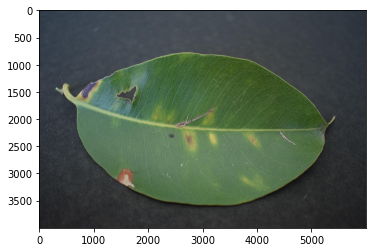

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

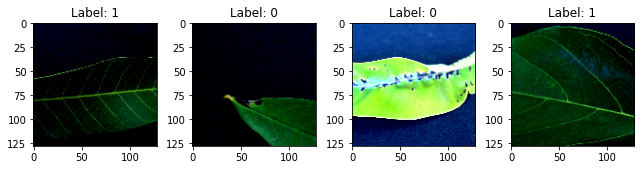

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:22] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:24] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2325417089550785 samples/sec                   batch loss = 1.649181604385376 | accuracy = 0.3


Epoch[1] Batch[10] Speed: 1.2776831075972463 samples/sec                   batch loss = 1.2080910205841064 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2792848724166719 samples/sec                   batch loss = 0.7438077926635742 | accuracy = 0.43333333333333335


Epoch[1] Batch[20] Speed: 1.2692039424172983 samples/sec                   batch loss = 0.4288625717163086 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2686728130629346 samples/sec                   batch loss = 0.33502522110939026 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.277986765233723 samples/sec                   batch loss = 0.42220109701156616 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2729247750369441 samples/sec                   batch loss = 0.7361723780632019 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2791319367540415 samples/sec                   batch loss = 0.7674046754837036 | accuracy = 0.56875


Epoch[1] Batch[45] Speed: 1.2711561583529387 samples/sec                   batch loss = 0.4256994128227234 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.2716693202072453 samples/sec                   batch loss = 0.9976668953895569 | accuracy = 0.585


Epoch[1] Batch[55] Speed: 1.273249558633499 samples/sec                   batch loss = 0.39211738109588623 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2714065211091536 samples/sec                   batch loss = 0.7977066040039062 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2745336013083535 samples/sec                   batch loss = 0.11774837970733643 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.283025003179417 samples/sec                   batch loss = 0.6369004845619202 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2757637735963263 samples/sec                   batch loss = 0.12300466746091843 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.2740274132967049 samples/sec                   batch loss = 0.3552693724632263 | accuracy = 0.6375


Epoch[1] Batch[85] Speed: 1.2727372450072998 samples/sec                   batch loss = 0.7673614025115967 | accuracy = 0.6470588235294118


Epoch[1] Batch[90] Speed: 1.2720074471032312 samples/sec                   batch loss = 0.5201902985572815 | accuracy = 0.6555555555555556


Epoch[1] Batch[95] Speed: 1.277278746871461 samples/sec                   batch loss = 0.6415889263153076 | accuracy = 0.6631578947368421


Epoch[1] Batch[100] Speed: 1.2730245496250858 samples/sec                   batch loss = 0.9324681758880615 | accuracy = 0.66


Epoch[1] Batch[105] Speed: 1.2734961067667414 samples/sec                   batch loss = 0.565497100353241 | accuracy = 0.6571428571428571


Epoch[1] Batch[110] Speed: 1.2703224557363402 samples/sec                   batch loss = 0.8272117376327515 | accuracy = 0.6590909090909091


Epoch[1] Batch[115] Speed: 1.2756862665781192 samples/sec                   batch loss = 0.40910640358924866 | accuracy = 0.6608695652173913


Epoch[1] Batch[120] Speed: 1.2759788830761456 samples/sec                   batch loss = 1.5229239463806152 | accuracy = 0.65625


Epoch[1] Batch[125] Speed: 1.271005063651708 samples/sec                   batch loss = 0.7250837087631226 | accuracy = 0.65


Epoch[1] Batch[130] Speed: 1.2762164901448023 samples/sec                   batch loss = 0.7142599821090698 | accuracy = 0.6423076923076924


Epoch[1] Batch[135] Speed: 1.2763609612182065 samples/sec                   batch loss = 2.327572822570801 | accuracy = 0.6388888888888888


Epoch[1] Batch[140] Speed: 1.2713401398448572 samples/sec                   batch loss = 0.6370506882667542 | accuracy = 0.6446428571428572


Epoch[1] Batch[145] Speed: 1.269227562755864 samples/sec                   batch loss = 0.6412962079048157 | accuracy = 0.6431034482758621


Epoch[1] Batch[150] Speed: 1.2715139597581662 samples/sec                   batch loss = 0.4367961287498474 | accuracy = 0.65


Epoch[1] Batch[155] Speed: 1.2698766978241767 samples/sec                   batch loss = 0.3601347804069519 | accuracy = 0.6516129032258065


Epoch[1] Batch[160] Speed: 1.2727165833890208 samples/sec                   batch loss = 0.5997076034545898 | accuracy = 0.65625


Epoch[1] Batch[165] Speed: 1.269341932193939 samples/sec                   batch loss = 0.332454115152359 | accuracy = 0.6606060606060606


Epoch[1] Batch[170] Speed: 1.274878000221887 samples/sec                   batch loss = 1.0496389865875244 | accuracy = 0.6573529411764706


Epoch[1] Batch[175] Speed: 1.2750740110247605 samples/sec                   batch loss = 0.6629294753074646 | accuracy = 0.6585714285714286


Epoch[1] Batch[180] Speed: 1.275512758726681 samples/sec                   batch loss = 0.5965031385421753 | accuracy = 0.6597222222222222


Epoch[1] Batch[185] Speed: 1.2758903854147765 samples/sec                   batch loss = 0.5189934372901917 | accuracy = 0.6662162162162162


Epoch[1] Batch[190] Speed: 1.2727747079699767 samples/sec                   batch loss = 0.49534931778907776 | accuracy = 0.6671052631578948


Epoch[1] Batch[195] Speed: 1.2712466012378754 samples/sec                   batch loss = 0.32559502124786377 | accuracy = 0.6679487179487179


Epoch[1] Batch[200] Speed: 1.2708520795552098 samples/sec                   batch loss = 0.551065981388092 | accuracy = 0.6625


Epoch[1] Batch[205] Speed: 1.2779616496088622 samples/sec                   batch loss = 0.2835480868816376 | accuracy = 0.6634146341463415


Epoch[1] Batch[210] Speed: 1.2711105083656815 samples/sec                   batch loss = 0.5416679978370667 | accuracy = 0.669047619047619


Epoch[1] Batch[215] Speed: 1.2679974031215446 samples/sec                   batch loss = 0.9691697955131531 | accuracy = 0.672093023255814


Epoch[1] Batch[220] Speed: 1.273037203667168 samples/sec                   batch loss = 0.29370248317718506 | accuracy = 0.6715909090909091


Epoch[1] Batch[225] Speed: 1.2659204595374716 samples/sec                   batch loss = 0.6231755018234253 | accuracy = 0.67


Epoch[1] Batch[230] Speed: 1.2719266351063303 samples/sec                   batch loss = 0.3474107086658478 | accuracy = 0.675


Epoch[1] Batch[235] Speed: 1.2777945292941115 samples/sec                   batch loss = 0.5579567551612854 | accuracy = 0.6723404255319149


Epoch[1] Batch[240] Speed: 1.2775975839499196 samples/sec                   batch loss = 0.4984756112098694 | accuracy = 0.675


Epoch[1] Batch[245] Speed: 1.2689269971350619 samples/sec                   batch loss = 0.32004043459892273 | accuracy = 0.676530612244898


Epoch[1] Batch[250] Speed: 1.2727721974963193 samples/sec                   batch loss = 0.603205680847168 | accuracy = 0.677


Epoch[1] Batch[255] Speed: 1.2685456153361312 samples/sec                   batch loss = 0.5469960570335388 | accuracy = 0.6745098039215687


Epoch[1] Batch[260] Speed: 1.270927267262026 samples/sec                   batch loss = 0.5793930292129517 | accuracy = 0.6730769230769231


Epoch[1] Batch[265] Speed: 1.2717407486353427 samples/sec                   batch loss = 0.2220018357038498 | accuracy = 0.6745283018867925


Epoch[1] Batch[270] Speed: 1.2779307918399643 samples/sec                   batch loss = 0.4950898289680481 | accuracy = 0.6796296296296296


Epoch[1] Batch[275] Speed: 1.269248783403218 samples/sec                   batch loss = 0.5520692467689514 | accuracy = 0.6772727272727272


Epoch[1] Batch[280] Speed: 1.2737650893704355 samples/sec                   batch loss = 0.4624151885509491 | accuracy = 0.6758928571428572


Epoch[1] Batch[285] Speed: 1.2711597218865323 samples/sec                   batch loss = 1.078374981880188 | accuracy = 0.6771929824561403


Epoch[1] Batch[290] Speed: 1.2684557481581091 samples/sec                   batch loss = 0.2840992212295532 | accuracy = 0.6801724137931034


Epoch[1] Batch[295] Speed: 1.2708769165076355 samples/sec                   batch loss = 0.5214874148368835 | accuracy = 0.6796610169491526


Epoch[1] Batch[300] Speed: 1.2705464142570178 samples/sec                   batch loss = 0.5420892238616943 | accuracy = 0.6775


Epoch[1] Batch[305] Speed: 1.271337249671523 samples/sec                   batch loss = 0.5349624156951904 | accuracy = 0.6770491803278689


Epoch[1] Batch[310] Speed: 1.2731914872949617 samples/sec                   batch loss = 0.3552192747592926 | accuracy = 0.6806451612903226


Epoch[1] Batch[315] Speed: 1.2751799381366697 samples/sec                   batch loss = 0.30329087376594543 | accuracy = 0.680952380952381


Epoch[1] Batch[320] Speed: 1.2709391094147293 samples/sec                   batch loss = 0.26821139454841614 | accuracy = 0.68203125


Epoch[1] Batch[325] Speed: 1.2715238855002065 samples/sec                   batch loss = 0.22994601726531982 | accuracy = 0.6823076923076923


Epoch[1] Batch[330] Speed: 1.2712073981090417 samples/sec                   batch loss = 0.7061102390289307 | accuracy = 0.6818181818181818


Epoch[1] Batch[335] Speed: 1.2668406961349887 samples/sec                   batch loss = 0.4426705539226532 | accuracy = 0.6828358208955224


Epoch[1] Batch[340] Speed: 1.2687145463808374 samples/sec                   batch loss = 0.3318828046321869 | accuracy = 0.6845588235294118


Epoch[1] Batch[345] Speed: 1.2706158882272294 samples/sec                   batch loss = 0.902211606502533 | accuracy = 0.6811594202898551


Epoch[1] Batch[350] Speed: 1.269654224412222 samples/sec                   batch loss = 0.1751697063446045 | accuracy = 0.6814285714285714


Epoch[1] Batch[355] Speed: 1.2735231739216903 samples/sec                   batch loss = 0.15991777181625366 | accuracy = 0.6823943661971831


Epoch[1] Batch[360] Speed: 1.2695943669087293 samples/sec                   batch loss = 0.41106081008911133 | accuracy = 0.6854166666666667


Epoch[1] Batch[365] Speed: 1.2689166320329066 samples/sec                   batch loss = 0.5650078654289246 | accuracy = 0.6876712328767123


Epoch[1] Batch[370] Speed: 1.2685068663467503 samples/sec                   batch loss = 0.5192588567733765 | accuracy = 0.6878378378378378


Epoch[1] Batch[375] Speed: 1.2665129588493143 samples/sec                   batch loss = 0.42929792404174805 | accuracy = 0.6893333333333334


Epoch[1] Batch[380] Speed: 1.2666381235726722 samples/sec                   batch loss = 0.30396369099617004 | accuracy = 0.6914473684210526


Epoch[1] Batch[385] Speed: 1.2711938172450372 samples/sec                   batch loss = 0.6403132081031799 | accuracy = 0.6896103896103896


Epoch[1] Batch[390] Speed: 1.2714187575995601 samples/sec                   batch loss = 0.5972354412078857 | accuracy = 0.6897435897435897


Epoch[1] Batch[395] Speed: 1.274724954108365 samples/sec                   batch loss = 0.7465556859970093 | accuracy = 0.6873417721518987


Epoch[1] Batch[400] Speed: 1.2744356230289686 samples/sec                   batch loss = 0.5852108597755432 | accuracy = 0.68625


Epoch[1] Batch[405] Speed: 1.2717663915668047 samples/sec                   batch loss = 0.4814496338367462 | accuracy = 0.6876543209876543


Epoch[1] Batch[410] Speed: 1.2752564143005962 samples/sec                   batch loss = 0.5451000332832336 | accuracy = 0.6908536585365853


Epoch[1] Batch[415] Speed: 1.2736649085959622 samples/sec                   batch loss = 0.6786692142486572 | accuracy = 0.6909638554216867


Epoch[1] Batch[420] Speed: 1.270425766995389 samples/sec                   batch loss = 0.2245693951845169 | accuracy = 0.6910714285714286


Epoch[1] Batch[425] Speed: 1.2715275474635865 samples/sec                   batch loss = 0.500831663608551 | accuracy = 0.691764705882353


Epoch[1] Batch[430] Speed: 1.27198381962187 samples/sec                   batch loss = 0.5030202269554138 | accuracy = 0.6906976744186046


Epoch[1] Batch[435] Speed: 1.2703953682694502 samples/sec                   batch loss = 0.96892911195755 | accuracy = 0.6913793103448276


Epoch[1] Batch[440] Speed: 1.2732225997327156 samples/sec                   batch loss = 0.4625067114830017 | accuracy = 0.6914772727272728


Epoch[1] Batch[445] Speed: 1.2695289432527792 samples/sec                   batch loss = 0.6709065437316895 | accuracy = 0.6887640449438203


Epoch[1] Batch[450] Speed: 1.2693560497500664 samples/sec                   batch loss = 0.5772818326950073 | accuracy = 0.6872222222222222


Epoch[1] Batch[455] Speed: 1.2670892659956725 samples/sec                   batch loss = 0.2171878218650818 | accuracy = 0.6884615384615385


Epoch[1] Batch[460] Speed: 1.277744995328374 samples/sec                   batch loss = 0.4480133056640625 | accuracy = 0.6880434782608695


Epoch[1] Batch[465] Speed: 1.2743817026756963 samples/sec                   batch loss = 0.5096511840820312 | accuracy = 0.6876344086021505


Epoch[1] Batch[470] Speed: 1.2744917747455 samples/sec                   batch loss = 0.9382247924804688 | accuracy = 0.6856382978723404


Epoch[1] Batch[475] Speed: 1.275188176572791 samples/sec                   batch loss = 0.7803762555122375 | accuracy = 0.6852631578947368


Epoch[1] Batch[480] Speed: 1.2700840574821273 samples/sec                   batch loss = 0.5406418442726135 | accuracy = 0.6869791666666667


Epoch[1] Batch[485] Speed: 1.2727468036464558 samples/sec                   batch loss = 0.7927719354629517 | accuracy = 0.6865979381443299


Epoch[1] Batch[490] Speed: 1.2751071537553311 samples/sec                   batch loss = 0.8548738956451416 | accuracy = 0.6862244897959183


Epoch[1] Batch[495] Speed: 1.2734156854375098 samples/sec                   batch loss = 1.2788788080215454 | accuracy = 0.6868686868686869


Epoch[1] Batch[500] Speed: 1.2693957150407118 samples/sec                   batch loss = 0.26799169182777405 | accuracy = 0.688


Epoch[1] Batch[505] Speed: 1.2696824737337205 samples/sec                   batch loss = 1.4403295516967773 | accuracy = 0.6866336633663367


Epoch[1] Batch[510] Speed: 1.2685615376367843 samples/sec                   batch loss = 0.6257535815238953 | accuracy = 0.6877450980392157


Epoch[1] Batch[515] Speed: 1.274480059927215 samples/sec                   batch loss = 0.4176604747772217 | accuracy = 0.6893203883495146


Epoch[1] Batch[520] Speed: 1.2709067606415008 samples/sec                   batch loss = 0.25466346740722656 | accuracy = 0.6913461538461538


Epoch[1] Batch[525] Speed: 1.2759079481189668 samples/sec                   batch loss = 0.23432327806949615 | accuracy = 0.6914285714285714


Epoch[1] Batch[530] Speed: 1.2719955850334819 samples/sec                   batch loss = 0.8968783617019653 | accuracy = 0.6900943396226416


Epoch[1] Batch[535] Speed: 1.27646554838961 samples/sec                   batch loss = 0.25765618681907654 | accuracy = 0.6906542056074766


Epoch[1] Batch[540] Speed: 1.268835540550863 samples/sec                   batch loss = 0.5620505809783936 | accuracy = 0.6925925925925925


Epoch[1] Batch[545] Speed: 1.2718841116754 samples/sec                   batch loss = 0.8235124945640564 | accuracy = 0.6926605504587156


Epoch[1] Batch[550] Speed: 1.2700555018539603 samples/sec                   batch loss = 0.2273218333721161 | accuracy = 0.6936363636363636


Epoch[1] Batch[555] Speed: 1.2674926580127932 samples/sec                   batch loss = 0.5845702290534973 | accuracy = 0.6936936936936937


Epoch[1] Batch[560] Speed: 1.2695546892026055 samples/sec                   batch loss = 0.49329236149787903 | accuracy = 0.69375


Epoch[1] Batch[565] Speed: 1.26856345601324 samples/sec                   batch loss = 0.7785610556602478 | accuracy = 0.6938053097345133


Epoch[1] Batch[570] Speed: 1.2690595510081697 samples/sec                   batch loss = 0.5257452726364136 | accuracy = 0.6934210526315789


Epoch[1] Batch[575] Speed: 1.2662828694746129 samples/sec                   batch loss = 0.6515483260154724 | accuracy = 0.6930434782608695


Epoch[1] Batch[580] Speed: 1.2664774888543942 samples/sec                   batch loss = 0.35653436183929443 | accuracy = 0.6948275862068966


Epoch[1] Batch[585] Speed: 1.2671655404292885 samples/sec                   batch loss = 0.5902987122535706 | accuracy = 0.6961538461538461


Epoch[1] Batch[590] Speed: 1.2723770179679892 samples/sec                   batch loss = 0.7210802435874939 | accuracy = 0.6957627118644067


Epoch[1] Batch[595] Speed: 1.2705793220326917 samples/sec                   batch loss = 0.28956204652786255 | accuracy = 0.6983193277310924


Epoch[1] Batch[600] Speed: 1.267861717568149 samples/sec                   batch loss = 0.8872876763343811 | accuracy = 0.6979166666666666


Epoch[1] Batch[605] Speed: 1.2681061833458238 samples/sec                   batch loss = 0.6786848306655884 | accuracy = 0.6979338842975207


Epoch[1] Batch[610] Speed: 1.2740738535647258 samples/sec                   batch loss = 0.25937750935554504 | accuracy = 0.6991803278688524


Epoch[1] Batch[615] Speed: 1.2755828738800303 samples/sec                   batch loss = 0.8375176191329956 | accuracy = 0.7


Epoch[1] Batch[620] Speed: 1.272129552484886 samples/sec                   batch loss = 0.11192940175533295 | accuracy = 0.7020161290322581


Epoch[1] Batch[625] Speed: 1.270947678264461 samples/sec                   batch loss = 0.6350063681602478 | accuracy = 0.7016


Epoch[1] Batch[630] Speed: 1.270005989246003 samples/sec                   batch loss = 0.5449159145355225 | accuracy = 0.7007936507936507


Epoch[1] Batch[635] Speed: 1.2626479351339814 samples/sec                   batch loss = 0.5495625138282776 | accuracy = 0.7


Epoch[1] Batch[640] Speed: 1.2668465313377566 samples/sec                   batch loss = 0.5164523124694824 | accuracy = 0.7


Epoch[1] Batch[645] Speed: 1.2648639389724765 samples/sec                   batch loss = 0.34800565242767334 | accuracy = 0.7007751937984497


Epoch[1] Batch[650] Speed: 1.2662353707809741 samples/sec                   batch loss = 0.25518688559532166 | accuracy = 0.7019230769230769


Epoch[1] Batch[655] Speed: 1.2642928931859205 samples/sec                   batch loss = 0.35972166061401367 | accuracy = 0.7015267175572519


Epoch[1] Batch[660] Speed: 1.264840194697088 samples/sec                   batch loss = 0.33764252066612244 | accuracy = 0.7018939393939394


Epoch[1] Batch[665] Speed: 1.2755978095005076 samples/sec                   batch loss = 0.3602297902107239 | accuracy = 0.7026315789473684


Epoch[1] Batch[670] Speed: 1.2674159612127511 samples/sec                   batch loss = 0.3801834285259247 | accuracy = 0.7037313432835821


Epoch[1] Batch[675] Speed: 1.2699569611472505 samples/sec                   batch loss = 0.13593466579914093 | accuracy = 0.7048148148148148


Epoch[1] Batch[680] Speed: 1.271047624617808 samples/sec                   batch loss = 0.19416087865829468 | accuracy = 0.7069852941176471


Epoch[1] Batch[685] Speed: 1.2682266780296862 samples/sec                   batch loss = 0.3104129135608673 | accuracy = 0.7072992700729926


Epoch[1] Batch[690] Speed: 1.2678868210389873 samples/sec                   batch loss = 1.8455899953842163 | accuracy = 0.7072463768115942


Epoch[1] Batch[695] Speed: 1.2777594950504498 samples/sec                   batch loss = 0.47275903820991516 | accuracy = 0.7075539568345324


Epoch[1] Batch[700] Speed: 1.2691772505724728 samples/sec                   batch loss = 1.3334282636642456 | accuracy = 0.7067857142857142


Epoch[1] Batch[705] Speed: 1.26998147472344 samples/sec                   batch loss = 0.9241660833358765 | accuracy = 0.7078014184397163


Epoch[1] Batch[710] Speed: 1.2708800933971596 samples/sec                   batch loss = 1.1039971113204956 | accuracy = 0.7077464788732394


Epoch[1] Batch[715] Speed: 1.280278185445568 samples/sec                   batch loss = 0.5695550441741943 | accuracy = 0.708041958041958


Epoch[1] Batch[720] Speed: 1.2719015642588207 samples/sec                   batch loss = 0.4113444685935974 | accuracy = 0.7083333333333334


Epoch[1] Batch[725] Speed: 1.2683300322049018 samples/sec                   batch loss = 0.7782538533210754 | accuracy = 0.7082758620689655


Epoch[1] Batch[730] Speed: 1.2703813237798132 samples/sec                   batch loss = 0.35636106133461 | accuracy = 0.7095890410958904


Epoch[1] Batch[735] Speed: 1.2636986613493133 samples/sec                   batch loss = 0.542475700378418 | accuracy = 0.7095238095238096


Epoch[1] Batch[740] Speed: 1.270804718755229 samples/sec                   batch loss = 0.8350528478622437 | accuracy = 0.7094594594594594


Epoch[1] Batch[745] Speed: 1.2714852434354744 samples/sec                   batch loss = 0.37937113642692566 | accuracy = 0.7104026845637584


Epoch[1] Batch[750] Speed: 1.2722281412301408 samples/sec                   batch loss = 0.6970650553703308 | accuracy = 0.711


Epoch[1] Batch[755] Speed: 1.2693536487829848 samples/sec                   batch loss = 0.7067505121231079 | accuracy = 0.7119205298013245


Epoch[1] Batch[760] Speed: 1.2752717300213738 samples/sec                   batch loss = 0.34372478723526 | accuracy = 0.7134868421052631


Epoch[1] Batch[765] Speed: 1.2703394807371553 samples/sec                   batch loss = 0.7453786730766296 | accuracy = 0.7133986928104575


Epoch[1] Batch[770] Speed: 1.2748811971464367 samples/sec                   batch loss = 0.514766275882721 | accuracy = 0.7136363636363636


Epoch[1] Batch[775] Speed: 1.2692174807964958 samples/sec                   batch loss = 0.4867727756500244 | accuracy = 0.7141935483870968


Epoch[1] Batch[780] Speed: 1.266847870572206 samples/sec                   batch loss = 0.5261828899383545 | accuracy = 0.7150641025641026


Epoch[1] Batch[785] Speed: 1.2676888946986247 samples/sec                   batch loss = 0.5302907228469849 | accuracy = 0.7156050955414013


[Epoch 1] training: accuracy=0.7157360406091371
[Epoch 1] time cost: 647.9209446907043
[Epoch 1] validation: validation accuracy=0.7


Epoch[2] Batch[5] Speed: 1.2726558575626887 samples/sec                   batch loss = 0.11759208142757416 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2728844060276754 samples/sec                   batch loss = 0.6580183506011963 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2696618150927903 samples/sec                   batch loss = 0.7696391940116882 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.2766173613769058 samples/sec                   batch loss = 0.5324334502220154 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2702164685378086 samples/sec                   batch loss = 0.5784273147583008 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.273464884299269 samples/sec                   batch loss = 0.7085361480712891 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2686214896435557 samples/sec                   batch loss = 0.40858379006385803 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.266423857406299 samples/sec                   batch loss = 0.896457314491272 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2820061667240659 samples/sec                   batch loss = 0.25187310576438904 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.2802665594055647 samples/sec                   batch loss = 0.47627949714660645 | accuracy = 0.76


Epoch[2] Batch[55] Speed: 1.278412712975238 samples/sec                   batch loss = 0.7903470396995544 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.2744840293869732 samples/sec                   batch loss = 0.8180113434791565 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2787195439137369 samples/sec                   batch loss = 0.4041944742202759 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2764866232741365 samples/sec                   batch loss = 0.33375316858291626 | accuracy = 0.75


Epoch[2] Batch[75] Speed: 1.2727501829976815 samples/sec                   batch loss = 0.6086274981498718 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.275701980631661 samples/sec                   batch loss = 0.17781467735767365 | accuracy = 0.75625


Epoch[2] Batch[85] Speed: 1.2742645844148595 samples/sec                   batch loss = 0.7126173973083496 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2769475311244818 samples/sec                   batch loss = 0.30270761251449585 | accuracy = 0.7527777777777778


Epoch[2] Batch[95] Speed: 1.2747623404630055 samples/sec                   batch loss = 0.17023256421089172 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.2765790890560909 samples/sec                   batch loss = 0.7323691248893738 | accuracy = 0.76


Epoch[2] Batch[105] Speed: 1.2778508800659047 samples/sec                   batch loss = 0.42542505264282227 | accuracy = 0.7690476190476191


Epoch[2] Batch[110] Speed: 1.2690932457982678 samples/sec                   batch loss = 0.9663641452789307 | accuracy = 0.7704545454545455


Epoch[2] Batch[115] Speed: 1.2753902939008135 samples/sec                   batch loss = 0.5929931998252869 | accuracy = 0.7652173913043478


Epoch[2] Batch[120] Speed: 1.2741509712380659 samples/sec                   batch loss = 1.3053030967712402 | accuracy = 0.76875


Epoch[2] Batch[125] Speed: 1.2732337116861345 samples/sec                   batch loss = 0.5390840768814087 | accuracy = 0.768


Epoch[2] Batch[130] Speed: 1.2775892170634742 samples/sec                   batch loss = 0.6394526362419128 | accuracy = 0.7673076923076924


Epoch[2] Batch[135] Speed: 1.2753724545901948 samples/sec                   batch loss = 0.42555901408195496 | accuracy = 0.7685185185185185


Epoch[2] Batch[140] Speed: 1.274700935016846 samples/sec                   batch loss = 0.1940957009792328 | accuracy = 0.7625


Epoch[2] Batch[145] Speed: 1.2798466004173847 samples/sec                   batch loss = 0.15083898603916168 | accuracy = 0.7637931034482759


Epoch[2] Batch[150] Speed: 1.2812739228639805 samples/sec                   batch loss = 0.8149116039276123 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.2794489677869296 samples/sec                   batch loss = 0.389333039522171 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2776644256866871 samples/sec                   batch loss = 0.3277904987335205 | accuracy = 0.759375


Epoch[2] Batch[165] Speed: 1.2758722410292933 samples/sec                   batch loss = 0.5264892578125 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.2749666481621438 samples/sec                   batch loss = 0.5008243918418884 | accuracy = 0.7573529411764706


Epoch[2] Batch[175] Speed: 1.2803508774071997 samples/sec                   batch loss = 0.4904777407646179 | accuracy = 0.7571428571428571


Epoch[2] Batch[180] Speed: 1.2764739976837054 samples/sec                   batch loss = 0.49642878770828247 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.271054557895839 samples/sec                   batch loss = 0.2771700322628021 | accuracy = 0.754054054054054


Epoch[2] Batch[190] Speed: 1.2743309810505616 samples/sec                   batch loss = 0.4165886640548706 | accuracy = 0.7539473684210526


Epoch[2] Batch[195] Speed: 1.2793095523244367 samples/sec                   batch loss = 0.18987604975700378 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.272850702763561 samples/sec                   batch loss = 0.6344020962715149 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2794396984962946 samples/sec                   batch loss = 0.3878076374530792 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2795298602442218 samples/sec                   batch loss = 0.7588360905647278 | accuracy = 0.7476190476190476


Epoch[2] Batch[215] Speed: 1.280713678948291 samples/sec                   batch loss = 0.6793512105941772 | accuracy = 0.7476744186046511


Epoch[2] Batch[220] Speed: 1.2745071689250635 samples/sec                   batch loss = 0.3116722106933594 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.2768476265567492 samples/sec                   batch loss = 0.45181480050086975 | accuracy = 0.7533333333333333


Epoch[2] Batch[230] Speed: 1.2757174040606634 samples/sec                   batch loss = 0.3315455913543701 | accuracy = 0.7543478260869565


Epoch[2] Batch[235] Speed: 1.2763750411296044 samples/sec                   batch loss = 0.4786257743835449 | accuracy = 0.7542553191489362


Epoch[2] Batch[240] Speed: 1.2763782455666264 samples/sec                   batch loss = 0.615329921245575 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.2717770924943832 samples/sec                   batch loss = 0.6158209443092346 | accuracy = 0.7510204081632653


Epoch[2] Batch[250] Speed: 1.2726407011456804 samples/sec                   batch loss = 1.1328942775726318 | accuracy = 0.752


Epoch[2] Batch[255] Speed: 1.270135980095983 samples/sec                   batch loss = 0.24151693284511566 | accuracy = 0.753921568627451


Epoch[2] Batch[260] Speed: 1.273897495282646 samples/sec                   batch loss = 0.13532021641731262 | accuracy = 0.7519230769230769


Epoch[2] Batch[265] Speed: 1.2746259780275149 samples/sec                   batch loss = 0.19488126039505005 | accuracy = 0.7509433962264151


Epoch[2] Batch[270] Speed: 1.277728355113281 samples/sec                   batch loss = 0.29574814438819885 | accuracy = 0.75


Epoch[2] Batch[275] Speed: 1.276004600159063 samples/sec                   batch loss = 0.31842076778411865 | accuracy = 0.7490909090909091


Epoch[2] Batch[280] Speed: 1.273846715473671 samples/sec                   batch loss = 0.6822672486305237 | accuracy = 0.75


Epoch[2] Batch[285] Speed: 1.2693952348165578 samples/sec                   batch loss = 0.5143600106239319 | accuracy = 0.75


Epoch[2] Batch[290] Speed: 1.2701049221704532 samples/sec                   batch loss = 0.24072958528995514 | accuracy = 0.7517241379310344


Epoch[2] Batch[295] Speed: 1.273179023421958 samples/sec                   batch loss = 0.7075490951538086 | accuracy = 0.7542372881355932


Epoch[2] Batch[300] Speed: 1.2795881208586195 samples/sec                   batch loss = 0.21712422370910645 | accuracy = 0.7516666666666667


Epoch[2] Batch[305] Speed: 1.280219861977334 samples/sec                   batch loss = 0.6879556775093079 | accuracy = 0.7516393442622951


Epoch[2] Batch[310] Speed: 1.2773933075868207 samples/sec                   batch loss = 0.38322770595550537 | accuracy = 0.7516129032258064


Epoch[2] Batch[315] Speed: 1.2747442281468746 samples/sec                   batch loss = 0.4302634298801422 | accuracy = 0.7531746031746032


Epoch[2] Batch[320] Speed: 1.2765233360252815 samples/sec                   batch loss = 0.14885954558849335 | accuracy = 0.75078125


Epoch[2] Batch[325] Speed: 1.2757018836301428 samples/sec                   batch loss = 0.5465964078903198 | accuracy = 0.7507692307692307


Epoch[2] Batch[330] Speed: 1.2799369171715933 samples/sec                   batch loss = 0.3613002896308899 | accuracy = 0.7507575757575757


Epoch[2] Batch[335] Speed: 1.2838867665785092 samples/sec                   batch loss = 0.5116426348686218 | accuracy = 0.75


Epoch[2] Batch[340] Speed: 1.2721321568834112 samples/sec                   batch loss = 0.6174453496932983 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2748481630325692 samples/sec                   batch loss = 0.6193267703056335 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2756499899330105 samples/sec                   batch loss = 0.6525248885154724 | accuracy = 0.7464285714285714


Epoch[2] Batch[355] Speed: 1.273745458112368 samples/sec                   batch loss = 0.341187983751297 | accuracy = 0.7464788732394366


Epoch[2] Batch[360] Speed: 1.2724863579417007 samples/sec                   batch loss = 0.5222864151000977 | accuracy = 0.7451388888888889


Epoch[2] Batch[365] Speed: 1.2738474892308618 samples/sec                   batch loss = 0.4943990409374237 | accuracy = 0.7452054794520548


Epoch[2] Batch[370] Speed: 1.2747803564324176 samples/sec                   batch loss = 0.5501838326454163 | accuracy = 0.7445945945945946


Epoch[2] Batch[375] Speed: 1.2708850031667558 samples/sec                   batch loss = 0.457002192735672 | accuracy = 0.744


Epoch[2] Batch[380] Speed: 1.2775142118485272 samples/sec                   batch loss = 0.5795179605484009 | accuracy = 0.7440789473684211


Epoch[2] Batch[385] Speed: 1.2783669299411824 samples/sec                   batch loss = 0.4329211115837097 | accuracy = 0.7454545454545455


Epoch[2] Batch[390] Speed: 1.2740570185763733 samples/sec                   batch loss = 0.3514449894428253 | accuracy = 0.7467948717948718


Epoch[2] Batch[395] Speed: 1.2737887830739894 samples/sec                   batch loss = 0.47105035185813904 | accuracy = 0.7481012658227848


Epoch[2] Batch[400] Speed: 1.2696090665432465 samples/sec                   batch loss = 0.8962115049362183 | accuracy = 0.74625


Epoch[2] Batch[405] Speed: 1.275627584800542 samples/sec                   batch loss = 0.6869422197341919 | accuracy = 0.7444444444444445


Epoch[2] Batch[410] Speed: 1.271328386555237 samples/sec                   batch loss = 0.5392788648605347 | accuracy = 0.7451219512195122


Epoch[2] Batch[415] Speed: 1.274548996498359 samples/sec                   batch loss = 0.5575418472290039 | accuracy = 0.7451807228915662


Epoch[2] Batch[420] Speed: 1.2730800940475147 samples/sec                   batch loss = 0.08221433311700821 | accuracy = 0.7464285714285714


Epoch[2] Batch[425] Speed: 1.2724863579417007 samples/sec                   batch loss = 0.8185635805130005 | accuracy = 0.7452941176470588


Epoch[2] Batch[430] Speed: 1.2704137420089983 samples/sec                   batch loss = 0.6882492303848267 | accuracy = 0.7465116279069768


Epoch[2] Batch[435] Speed: 1.27499309960762 samples/sec                   batch loss = 0.3736873269081116 | accuracy = 0.7488505747126437


Epoch[2] Batch[440] Speed: 1.2758356627408312 samples/sec                   batch loss = 1.1991262435913086 | accuracy = 0.75


Epoch[2] Batch[445] Speed: 1.274186872360731 samples/sec                   batch loss = 0.2261207550764084 | accuracy = 0.751685393258427


Epoch[2] Batch[450] Speed: 1.2782303796029453 samples/sec                   batch loss = 0.38543033599853516 | accuracy = 0.7522222222222222


Epoch[2] Batch[455] Speed: 1.2773933075868207 samples/sec                   batch loss = 0.21162909269332886 | accuracy = 0.7527472527472527


Epoch[2] Batch[460] Speed: 1.2809002420829825 samples/sec                   batch loss = 0.7117679119110107 | accuracy = 0.7521739130434782


Epoch[2] Batch[465] Speed: 1.271273091207309 samples/sec                   batch loss = 0.44898998737335205 | accuracy = 0.7521505376344086


Epoch[2] Batch[470] Speed: 1.266037577521825 samples/sec                   batch loss = 0.6034296751022339 | accuracy = 0.7526595744680851


Epoch[2] Batch[475] Speed: 1.2678621966327157 samples/sec                   batch loss = 0.9507129788398743 | accuracy = 0.7531578947368421


Epoch[2] Batch[480] Speed: 1.2683534282523543 samples/sec                   batch loss = 0.7824129462242126 | accuracy = 0.753125


Epoch[2] Batch[485] Speed: 1.2717363142483118 samples/sec                   batch loss = 0.658967137336731 | accuracy = 0.7536082474226804


Epoch[2] Batch[490] Speed: 1.274302814868827 samples/sec                   batch loss = 0.13590019941329956 | accuracy = 0.7525510204081632


Epoch[2] Batch[495] Speed: 1.2800899477265821 samples/sec                   batch loss = 0.33704760670661926 | accuracy = 0.7525252525252525


Epoch[2] Batch[500] Speed: 1.2807609990433158 samples/sec                   batch loss = 0.1539883017539978 | accuracy = 0.753


Epoch[2] Batch[505] Speed: 1.272826947380432 samples/sec                   batch loss = 0.16301417350769043 | accuracy = 0.753960396039604


Epoch[2] Batch[510] Speed: 1.2758026761626065 samples/sec                   batch loss = 0.8803338408470154 | accuracy = 0.753921568627451


Epoch[2] Batch[515] Speed: 1.2753561669598141 samples/sec                   batch loss = 0.13961300253868103 | accuracy = 0.7543689320388349


Epoch[2] Batch[520] Speed: 1.2755289533817922 samples/sec                   batch loss = 0.23578794300556183 | accuracy = 0.7548076923076923


Epoch[2] Batch[525] Speed: 1.278999220580576 samples/sec                   batch loss = 0.24818271398544312 | accuracy = 0.7547619047619047


Epoch[2] Batch[530] Speed: 1.275150765236419 samples/sec                   batch loss = 0.3722575008869171 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.2780685438753447 samples/sec                   batch loss = 0.1552102416753769 | accuracy = 0.7574766355140187


Epoch[2] Batch[540] Speed: 1.2743822834810448 samples/sec                   batch loss = 0.19882936775684357 | accuracy = 0.7587962962962963


Epoch[2] Batch[545] Speed: 1.2668543754655217 samples/sec                   batch loss = 0.4353296160697937 | accuracy = 0.7591743119266054


Epoch[2] Batch[550] Speed: 1.2693658457898862 samples/sec                   batch loss = 0.5819464325904846 | accuracy = 0.7604545454545455


Epoch[2] Batch[555] Speed: 1.270979643981799 samples/sec                   batch loss = 0.32796111702919006 | accuracy = 0.7612612612612613


Epoch[2] Batch[560] Speed: 1.274360406845165 samples/sec                   batch loss = 0.7266551852226257 | accuracy = 0.7616071428571428


Epoch[2] Batch[565] Speed: 1.273631744109064 samples/sec                   batch loss = 0.26677411794662476 | accuracy = 0.761504424778761


Epoch[2] Batch[570] Speed: 1.2715192598924017 samples/sec                   batch loss = 0.353085458278656 | accuracy = 0.762719298245614


Epoch[2] Batch[575] Speed: 1.2753909725800934 samples/sec                   batch loss = 0.8168548941612244 | accuracy = 0.7626086956521739


Epoch[2] Batch[580] Speed: 1.2706030898197354 samples/sec                   batch loss = 0.8799276351928711 | accuracy = 0.7625


Epoch[2] Batch[585] Speed: 1.2742506478072606 samples/sec                   batch loss = 0.29755914211273193 | accuracy = 0.7628205128205128


Epoch[2] Batch[590] Speed: 1.2707307967569628 samples/sec                   batch loss = 0.561730146408081 | accuracy = 0.763135593220339


Epoch[2] Batch[595] Speed: 1.2666086708239161 samples/sec                   batch loss = 0.07415880262851715 | accuracy = 0.7621848739495798


Epoch[2] Batch[600] Speed: 1.2745114290152917 samples/sec                   batch loss = 0.7826961278915405 | accuracy = 0.7620833333333333


Epoch[2] Batch[605] Speed: 1.275795011878345 samples/sec                   batch loss = 0.11957438290119171 | accuracy = 0.7611570247933884


Epoch[2] Batch[610] Speed: 1.2700150262107075 samples/sec                   batch loss = 0.9846422672271729 | accuracy = 0.7610655737704918


Epoch[2] Batch[615] Speed: 1.2732642464003636 samples/sec                   batch loss = 0.5027909874916077 | accuracy = 0.7617886178861789


Epoch[2] Batch[620] Speed: 1.2722535143873057 samples/sec                   batch loss = 0.4908730089664459 | accuracy = 0.7616935483870968


Epoch[2] Batch[625] Speed: 1.26681439056041 samples/sec                   batch loss = 0.3529031574726105 | accuracy = 0.7608


Epoch[2] Batch[630] Speed: 1.2697779926549546 samples/sec                   batch loss = 0.8816748857498169 | accuracy = 0.7611111111111111


Epoch[2] Batch[635] Speed: 1.2696438474261456 samples/sec                   batch loss = 0.21153490245342255 | accuracy = 0.760236220472441


Epoch[2] Batch[640] Speed: 1.2679336771228094 samples/sec                   batch loss = 0.18366371095180511 | accuracy = 0.7609375


Epoch[2] Batch[645] Speed: 1.2706230092573203 samples/sec                   batch loss = 0.17254021763801575 | accuracy = 0.7616279069767442


Epoch[2] Batch[650] Speed: 1.266344422378283 samples/sec                   batch loss = 0.21062740683555603 | accuracy = 0.7626923076923077


Epoch[2] Batch[655] Speed: 1.2669913763833491 samples/sec                   batch loss = 0.2793349325656891 | accuracy = 0.7625954198473283


Epoch[2] Batch[660] Speed: 1.265571717698993 samples/sec                   batch loss = 0.3677663505077362 | accuracy = 0.7632575757575758


Epoch[2] Batch[665] Speed: 1.2697927926468766 samples/sec                   batch loss = 0.6865910887718201 | accuracy = 0.762781954887218


Epoch[2] Batch[670] Speed: 1.2716134169139763 samples/sec                   batch loss = 0.669760525226593 | accuracy = 0.7615671641791045


Epoch[2] Batch[675] Speed: 1.263668298158911 samples/sec                   batch loss = 1.3338584899902344 | accuracy = 0.7614814814814815


Epoch[2] Batch[680] Speed: 1.276375332441396 samples/sec                   batch loss = 0.5725991129875183 | accuracy = 0.7617647058823529


Epoch[2] Batch[685] Speed: 1.2742611970169138 samples/sec                   batch loss = 0.2512589395046234 | accuracy = 0.7613138686131387


Epoch[2] Batch[690] Speed: 1.2746285926578176 samples/sec                   batch loss = 0.6552953720092773 | accuracy = 0.7615942028985507


Epoch[2] Batch[695] Speed: 1.2715070214674034 samples/sec                   batch loss = 0.4480115473270416 | accuracy = 0.7618705035971223


Epoch[2] Batch[700] Speed: 1.2779021742947159 samples/sec                   batch loss = 0.45515599846839905 | accuracy = 0.7617857142857143


Epoch[2] Batch[705] Speed: 1.2754521536367518 samples/sec                   batch loss = 0.6170099973678589 | accuracy = 0.7613475177304965


Epoch[2] Batch[710] Speed: 1.262360070538361 samples/sec                   batch loss = 0.43003901839256287 | accuracy = 0.7612676056338028


Epoch[2] Batch[715] Speed: 1.2654782623322198 samples/sec                   batch loss = 0.28131815791130066 | accuracy = 0.7622377622377622


Epoch[2] Batch[720] Speed: 1.2723648595202752 samples/sec                   batch loss = 0.515474259853363 | accuracy = 0.7631944444444444


Epoch[2] Batch[725] Speed: 1.2662629903120846 samples/sec                   batch loss = 0.31448009610176086 | accuracy = 0.763448275862069


Epoch[2] Batch[730] Speed: 1.2785250414160727 samples/sec                   batch loss = 0.28206461668014526 | accuracy = 0.7626712328767123


Epoch[2] Batch[735] Speed: 1.2712223277624652 samples/sec                   batch loss = 0.4954485595226288 | accuracy = 0.7625850340136054


Epoch[2] Batch[740] Speed: 1.2710092040730256 samples/sec                   batch loss = 0.35360798239707947 | accuracy = 0.7621621621621621


Epoch[2] Batch[745] Speed: 1.2729908389392541 samples/sec                   batch loss = 0.4782978296279907 | accuracy = 0.7624161073825504


Epoch[2] Batch[750] Speed: 1.2755630895706402 samples/sec                   batch loss = 0.5092760324478149 | accuracy = 0.762


Epoch[2] Batch[755] Speed: 1.2724543163913093 samples/sec                   batch loss = 0.10199250280857086 | accuracy = 0.7615894039735099


Epoch[2] Batch[760] Speed: 1.2734792870429534 samples/sec                   batch loss = 1.0833686590194702 | accuracy = 0.7618421052631579


Epoch[2] Batch[765] Speed: 1.276653013039621 samples/sec                   batch loss = 0.33992648124694824 | accuracy = 0.7630718954248366


Epoch[2] Batch[770] Speed: 1.2705589228598075 samples/sec                   batch loss = 0.5087416768074036 | accuracy = 0.7642857142857142


Epoch[2] Batch[775] Speed: 1.2714802326664432 samples/sec                   batch loss = 0.23843330144882202 | accuracy = 0.7648387096774194


Epoch[2] Batch[780] Speed: 1.266234319542347 samples/sec                   batch loss = 0.23116683959960938 | accuracy = 0.7647435897435897


Epoch[2] Batch[785] Speed: 1.2645225458143274 samples/sec                   batch loss = 0.5409450531005859 | accuracy = 0.7643312101910829


[Epoch 2] training: accuracy=0.7642766497461929
[Epoch 2] time cost: 637.435643196106
[Epoch 2] validation: validation accuracy=0.7711111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7377777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)